In [2]:
%load_ext autotime

In [52]:
%unload_ext autotime

In [1]:
## Import required modules:
import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Data Post-processing:

### Import reviews file (i.e. pre-processed amazon-book-reviews created by `reviews_preprocessing.ipynb` ):

In [2]:
col_names = ['productID', 'title', 'price', 'userID', 'profileName', 
             'helpfulness', 'score', 'time', 'summary', 'text']
books_amazon = pd.read_csv('E://MRP//0102/Books.csv', nrows = 10, encoding = 'utf-8', names=col_names)

In [3]:
books_amazon

,productID,title,price,userID,profileName,helpfulness,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,unknown,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a co...
1,826414346,Dr. Seuss,unknown,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after rea...
2,826414346,Dr. Seuss,unknown,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""..."
3,826414346,Dr. Seuss,unknown,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;..."
4,826414346,Dr. Seuss,unknown,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss
5,826414346,Dr. Seuss,unknown,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss"
6,826414346,Dr. Seuss,unknown,A14OJS0VWMOSWO,Midwest Book Review,3/4,5.0,1100131200,A memorably excellent survey of Dr. Seuss' ma...,Theodor Seuss Giesel was best known as 'Dr. S...
7,826414346,Dr. Seuss,unknown,A2RSSXTDZDUSH4,J. Squire,0/0,5.0,1231200000,Academia At It's Best,When I recieved this book as a gift for Chris...
8,826414346,Dr. Seuss,unknown,A25MD5I2GUIW6W,"J. P. HIGBED ""big fellow""",0/0,5.0,1209859200,And to think that I read it on the tram!,Trams (or any public transport) are not usual...
9,826414346,Dr. Seuss,unknown,A3VA4XFS5WNJO3,Donald Burnside,3/5,4.0,1076371200,Fascinating account of a genius at work,"As far as I am aware, this is the first book-..."


In [4]:
## Get all the book-names from Amaozn-data (later this list will be used to find crime-mystery books):
book_names = []
i = 0
with open ('E://MRP//0102/Books.csv') as books:
    for line in books:
        book_names.append(line.split(',')[1])

In [5]:
## Total unique books:
len(set(book_names))

752526

## Clean the book-names:

In [6]:
unique_books = list(set(book_names))
unique_books = [book.strip().lower() for book in unique_books]
unique_books.sort()

### Import goodreads file (i.e. data collected from `goodreads_data.ipynb`):

In [7]:
books_goodreads = pd.read_csv('E:/MRP/0331/Book-Recommender-System/data/books_df.csv', encoding = 'latin1')

books_goodreads['Books'] = [book.strip().lower() for book in books_goodreads['Books']]
books_goodreads['Total_Num_Ratings'] = [int(rating.replace(',','')) for rating in books_goodreads['Total_Num_Ratings']]
books_goodreads['Total_Num_Votes'] = [int(vote.replace(',','')) for vote in books_goodreads['Total_Num_Votes']]
books_goodreads['Avg_Rating'] = [float(rating.strip("['']")) for rating in books_goodreads['Avg_Rating']]

books_goodreads.head()

,Avg_Rating,Books,Total_Num_Ratings,Total_Num_Votes
0,4.12,"the girl with the dragon tattoo (millennium, #1)",2028253,2818
1,4.24,and then there were none,500620,2077
2,3.86,"angels & demons (robert langdon, #1)",2166178,1334
3,4.21,rebecca,342140,939
4,4.05,in cold blood,416759,765


### Found matches for only 1200 books out of 5000:

In [8]:
common_books = list(set(unique_books) & set(books_goodreads['Books']))
print (len(common_books))
common_books[0:10]

1200


['ripper',
 "pudd'nhead wilson",
 'true crime',
 'vanished',
 'catch a falling knife',
 'the meaning of night',
 'girl with a pearl earring',
 'tomato red',
 'layer cake',
 'room']

### Start building a recommendation system:

#### Efficient but incomplete method!

In [204]:
temp_book = ['Dr. Seuss', 'Its Only Art If Its Well Hung!']
# temp_books = set(common_books)

list_df = []
with open ('E://MRP//0102//Books.csv') as books:
    for i in range(5):
        line = books.readline()
        book = line.split(',')[1].strip()
        
        if book in temp_book:
            list_df.append(line)

 1882931173, Its Only Art If Its Well Hung!, unknown, AVCGYZL8FQQTD," Jim of Oz ""jim-of-oz""", 7/7, 4.0, 940636800, Nice collection of Julie Strain images," This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the place to find it -- there's only about 2 pages with text and everything else is photos.Bottom line"

 0826414346, Dr. Seuss, unknown, A30TK6U7DNS82R, Kevin Killian, 10/10, 5.0, 1095724800, Really Enjoyed It," I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compliment of treating him as a serious poet as well as one of the 20th century's most interesting visual artists, and after reading his book I decided that a trip to the Mandeville Collections of the library at University of California in San Die

#### Quick fix for incomplete-method:

In [9]:
## Load only required columns to avoid memory-issues:
books_amazon_whole = pd.read_csv('E://MRP//0102/Books.csv', encoding = 'utf-8', header=None, usecols=[0,1,3,6])
new_cols = ['BookID', 'BookTitle', 'UserID', 'Score']
books_amazon_whole.columns = new_cols
books_amazon_whole['BookTitle'] = [title.strip().lower() for title in books_amazon_whole['BookTitle']]
books_amazon_whole.head()

,BookID,BookTitle,UserID,Score
0,1882931173,its only art if its well hung!,AVCGYZL8FQQTD,4.0
1,0826414346,dr. seuss,A30TK6U7DNS82R,5.0
2,0826414346,dr. seuss,A3UH4UZ4RSVO82,5.0
3,0826414346,dr. seuss,A2MVUWT453QH61,4.0
4,0826414346,dr. seuss,A22X4XUPKF66MR,4.0


In [10]:
## Subset the previous data-frame to keep records for only crime-mystery books:
books_amazon_whole = books_amazon_whole[books_amazon_whole['BookTitle'].isin(common_books)]
books_amazon_whole.head()

,BookID,BookTitle,UserID,Score
6099,B000OX8HJO,trust no one,A3KKFG3TA9IO8X,5.0
8349,1563331586,chains,A3EX36SNRYD5VL,3.0
11895,B000N1ZWS6,a study in scarlet and the sign of four,A3MV1KKHX51FYT,5.0
12730,0451210530,a rip in heaven,A1IMO4Q54CHVH5,4.0
12731,0451210530,a rip in heaven,A24VKWUKXWBWLV,3.0


In [11]:
## Unique users
len(set(books_amazon_whole['UserID']))

101864

C:\Users\ref-patron\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


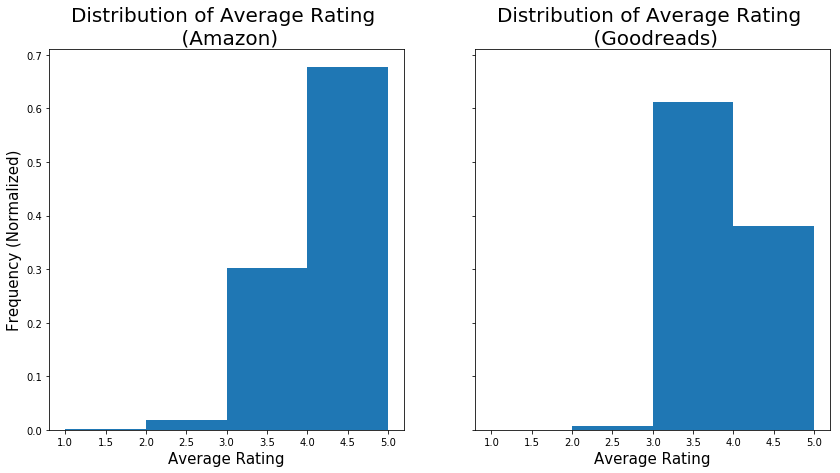

In [12]:
amazon_rating = pd.DataFrame(books_amazon_whole.groupby(by = 'BookTitle').mean()).reset_index(drop = False)

fig, (ax1, ax2) = plt.subplots(figsize= (14,7), ncols = 2, sharey = True)
ax1.hist(amazon_rating['Score'], bins = [1,2,3,4,5], normed = True)
ax1.set_xlabel('Average Rating', fontsize = 15)
ax1.set_ylabel('Frequency (Normalized)', fontsize = 15)
ax1.set_title('Distribution of Average Rating \n (Amazon)', fontsize = 20)

ax2.hist(books_goodreads['Avg_Rating'], bins = [1,2,3,4,5], normed = True)
ax2.set_xlabel('Average Rating', fontsize = 15)
# ax2.set_ylabel('Frequency (Normalized)', fontsize = 15)
ax2.set_title('Distribution of Average Rating \n (Goodreads)', fontsize = 20)

plt.show()

In [13]:
## Consider users who rated >1 books. Two reasons: 1) Expect to get better results; 2) Speeds-up calculation and easy to manage.
filter_users = pd.DataFrame(books_amazon_whole.groupby(by = 'UserID').size(), columns = ['count'])
filter_users = filter_users.loc[filter_users['count'] > 1]
filter_users.reset_index(drop = False, inplace = True)

filter_users = filter_users[filter_users['UserID'] != ' unknown']  ## Remove unknown user-ID which has given 949 ratings
filter_users = books_amazon_whole.loc[books_amazon_whole['UserID'].isin(filter_users['UserID'])]

In [14]:
## Unique users who rated more than 1 books
len(set(filter_users['UserID']))

58991

In [15]:
filter_users.head()

,BookID,BookTitle,UserID,Score
8349,1563331586,chains,A3EX36SNRYD5VL,3.0
11895,B000N1ZWS6,a study in scarlet and the sign of four,A3MV1KKHX51FYT,5.0
12730,0451210530,a rip in heaven,A1IMO4Q54CHVH5,4.0
12731,0451210530,a rip in heaven,A24VKWUKXWBWLV,3.0
12734,0451210530,a rip in heaven,A325JING4PW8FE,3.0


In [16]:
# books_amazon_whole.drop_duplicates(subset = ['BookTitle', 'UserID'], inplace = True)
user_item_df = pd.pivot_table(data = filter_users, index = 'UserID', columns = 'BookTitle', values = 'Score')
user_item_df.head()

BookTitle,13 for luck,24 hours,a cast of killers,a clockwork orange,a coffin for dimitrios,a cry in the night,a dark-adapted eye,a demon in my view,a discount for death,a dram of poison,...,widow's web,wildfire at midnight,windmills of the gods,windy city blues,wired,with murderous intent,woman on the run,worm,yellow-dog contract,you belong to me
UserID,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00878773S2MNB00COHKV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0134066213WYQXLTVGYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01487226AT9QN55VGVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0160198NNRLD37TTP2P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
## Fill NAs with 0 and get the new list of book-titles:
user_item_df.fillna(0, inplace=True)
new_book_names = user_item_df.columns
user_item_df.head()

BookTitle,13 for luck,24 hours,a cast of killers,a clockwork orange,a coffin for dimitrios,a cry in the night,a dark-adapted eye,a demon in my view,a discount for death,a dram of poison,...,widow's web,wildfire at midnight,windmills of the gods,windy city blues,wired,with murderous intent,woman on the run,worm,yellow-dog contract,you belong to me
UserID,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTDNU543WS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00878773S2MNB00COHKV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0134066213WYQXLTVGYT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01487226AT9QN55VGVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0160198NNRLD37TTP2P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
user_item_df.shape

(58991, 1128)

In [19]:
true_user_id = list(enumerate(user_item_df.index))
true_user_id[0:10]

[(0, ' A00540411RKGTDNU543WS'),
 (1, ' A00878773S2MNB00COHKV'),
 (2, ' A0134066213WYQXLTVGYT'),
 (3, ' A01487226AT9QN55VGVV'),
 (4, ' A0160198NNRLD37TTP2P'),
 (5, ' A018164216EMFRPKKUUN'),
 (6, ' A02052513V2AZPE5GHB3R'),
 (7, ' A02660181QI9HHAVFK06O'),
 (8, ' A03355352UQGJRUSZECK9'),
 (9, ' A03816223LL3Q1P48HRU')]

In [20]:
## Test mapping of user-ids:
user_0 = pd.DataFrame(user_item_df.loc[' A0134066213WYQXLTVGYT'])
user_0[user_0[' A0134066213WYQXLTVGYT'] > 0]

,A0134066213WYQXLTVGYT
BookTitle,
awakening,5.0
public secrets,5.0


### In practise, the user-item matrices are very sparse. Following two plots help in understanding the sparsity of the data in this case.

### Ratings per user (i.e. number of books rated by a user) is very less. Most users rated only 1 book. So, user-user model may not result in a good recommendation system.

In [21]:
user_data = [np.count_nonzero(user_item_df.iloc[i,:]) for i in range(user_item_df.shape[0])]
book_data = [np.count_nonzero(user_item_df.iloc[:,i]) for i in range(user_item_df.shape[1])]

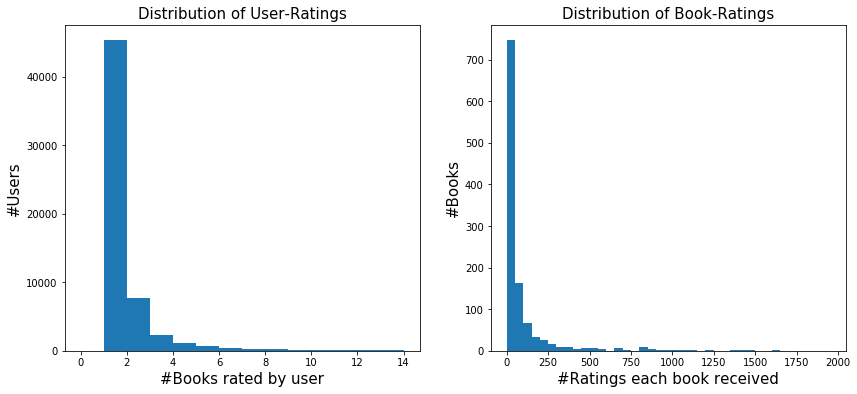

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
ax1.hist(user_data, bins = range(0,15,1))
ax2.hist(book_data, bins = range(0, 2000,50))

ax1.set_title('Distribution of User-Ratings', fontsize = 15)
ax2.set_title('Distribution of Book-Ratings', fontsize = 15)

ax1.set_xlabel('#Books rated by user', fontsize = 15)
ax2.set_xlabel('#Ratings each book received', fontsize = 15)

ax1.set_ylabel('#Users', fontsize = 15)
ax2.set_ylabel('#Books', fontsize = 15)

plt.show()

### Item-item recommendation system:

In [23]:
user_item_mat = csr_matrix(user_item_df)
user_item_mat

<58991x1128 sparse matrix of type '<class 'numpy.float64'>'
	with 98220 stored elements in Compressed Sparse Row format>

In [78]:
# def get_dense_users(row):
#     if np.count_nonzero(user_item_mat[row,:].toarray()) > 1:
#         return row        
    
# subset_matrix_ind = [get_dense_users(row) for row in range(user_item_mat.shape[0])]

In [24]:
book_similarity_mat = cosine_similarity(user_item_mat.transpose(), dense_output = False)
book_similarity_mat = book_similarity_mat.toarray()
book_similarity_mat.shape

(1128, 1128)

### Make recommendations (item-item similarity based on user-ratings):

In [25]:
def most_similar_books(book_ind, book_names):
    
    most_sim_books = np.argsort(book_similarity_mat[book_ind,:])[::-1][0:20]
    recommended_books = [book_names[i] for i in most_sim_books]
    
    recommendation_df = pd.DataFrame({'BookIndex': most_sim_books, 'BookTitle': recommended_books})
    
    print ('Target book: ', book_names[book_ind])
    
    return recommendation_df

most_similar_books(483, new_book_names)  ## Try: 837, 483

Target book:  my dark places


,BookIndex,BookTitle
0,483,my dark places
1,61,an inspector calls
2,883,the mammoth book of true crime
3,533,people of the book
4,735,the cleansing
5,727,the chinatown death cloud peril
6,1036,the wycherly woman
7,275,faithful unto death
8,201,dead weight
9,804,the fan


In [29]:
most_similar_books(book_ind = 483, book_names = new_book_names)

Target book:  my dark places


,BookIndex,BookTitle
0,483,my dark places
1,61,an inspector calls
2,883,the mammoth book of true crime
3,533,people of the book
4,735,the cleansing
5,727,the chinatown death cloud peril
6,1036,the wycherly woman
7,275,faithful unto death
8,201,dead weight
9,804,the fan


### Making it a bit more personalized, that is, consider other books that a user likes and recommend books accordingly:

### Matrix-Factorization Approach

### Splitting data into train / test set and evaluating performance

In [33]:
import random
from sklearn.decomposition import TruncatedSVD

In [202]:
random.seed(11)

user_ids_all = list(user_item_df.index)

train_ind = random.sample(k = 50000, population = range(58991))
train_user_ids = [user_ids_all[i] for i in train_ind]
train_data = csr_matrix(user_item_df.iloc[train_ind, :])

test_user_ids = [user_ids_all[j] for j in range(len(user_ids_all)) if j not in train_ind]
test_data = csr_matrix(user_item_df.loc[test_user_ids, :])

print ('Shape of training data: ', train_data.shape)
print ('Shape of testing data: ', test_data.shape)

Shape of training data:  (50000, 1128)
Shape of testing data:  (8991, 1128)


### Sklearn implementation of SVD:

In [203]:
def fit_svd(train, n_compo = 10, random_state = 11):
    
    tsvd = TruncatedSVD(n_components = n_compo, random_state = random_state)
    tsvd.fit(train)
    
    return tsvd

def predict_train(tsvd_obj, train):
    
    train_predictions = np.dot(tsvd_obj.transform(train), tsvd_obj.components_)
    
    return train_predictions

def predict_test(tsvd_obj, test):
    
    test_predictions = np.dot(tsvd_obj.transform(test), tsvd_obj.components_)
        
    return test_predictions

In [204]:
tsvd = fit_svd(train = train_data, n_compo = 25)
predict_ratings_train = predict_train(tsvd_obj = tsvd, train = train_data)
predict_ratings_train.shape

(50000, 1128)

In [205]:
predict_ratings_test = predict_test(tsvd_obj = tsvd, test = test_data)
predict_ratings_test.shape

(8991, 1128)

In [206]:
def plot_rmse(rmse_list, n_users = 500):
    
    fig, ax = plt.subplots(figsize = (14,8))
    ax.plot(rmse_list[0:n_users])
    ax.axhline(y = np.mean(rmse_list), label = 'Avg. RMSE: {}'.format(round(np.mean(rmse_list), 3)), 
               color = 'r', linestyle = 'dashed')
    ax.set_ylabel('RMSE', fontsize = 15)
    ax.set_xlabel('UserId', fontsize = 15)
    ax.set_title('RMSE for each user', fontsize = 20)
    ax.legend()
    plt.show()    
    
    return None

In [207]:
rmse_train = np.sqrt(np.mean((train_data.toarray() - predict_ratings_train)**2, axis = 1))

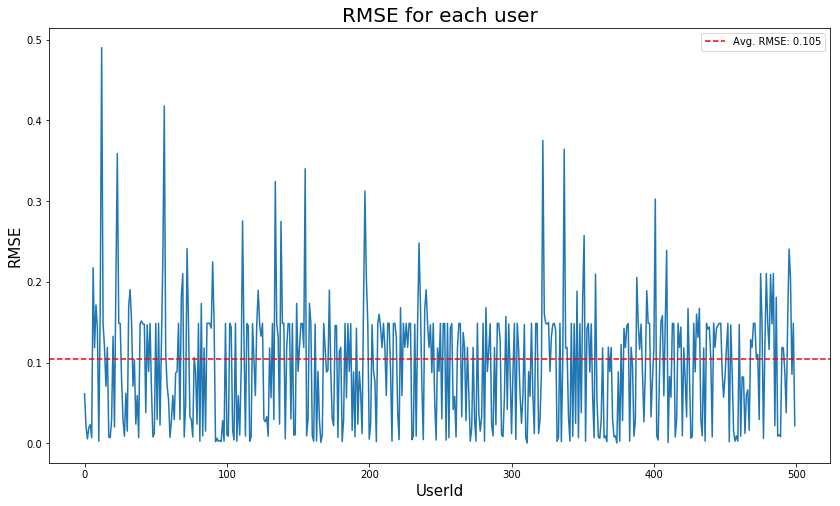

In [208]:
plot_rmse(rmse_train)

In [209]:
def get_recommended_books(user_id, books_list, latent_ratings, ui_mat, top_n = 15):
    
    ## Get recommendations for a given user:
    ind_top_rated_books = np.argsort(latent_ratings.iloc[user_id])[::-1][0:top_n]
    recommended_books = [books_list[ind] for ind in ind_top_rated_books]    
    recommendation_df = pd.DataFrame({'UserID': user_id, 'BookID': ind_top_rated_books, 
                                     'Recommended_Books': recommended_books})
    
    ## Get actual books that the user rated:
    user_rated_books = ui_mat[user_id,:].toarray()
    rated_books_ind = np.argwhere(user_rated_books != 0)[:,1]
    rated_books = [books_list[ind] for ind in rated_books_ind]
    user_rated_books_df = pd.DataFrame({'BookID': rated_books_ind, 'RatedBooks': rated_books, 'UserID': user_id})
    
    return user_rated_books_df, recommendation_df

## Try: 211
user_rated_books, recommended_books = get_recommended_books(user_id = 211, books_list = new_book_names, 
                                      latent_ratings = predict_ratings, ui_mat = user_item_mat)

In [216]:
rated_books, recommended_books = get_recommended_books(user_id = 100, books_list = new_book_names, 
                                      latent_ratings = pd.DataFrame(predict_ratings_train), ui_mat = train_data)

In [217]:
rated_books

,BookID,RatedBooks,UserID
0,937,the poisonwood bible,100


In [218]:
recommended_books

,UserID,BookID,Recommended_Books
1127,100,937,the poisonwood bible
1126,100,699,the blind assassin
1125,100,641,snow falling on cedars
1124,100,642,snow flower and the secret fan
1123,100,1092,under the tuscan sun
1122,100,934,the pilot's wife
1121,100,1006,the testament
1120,100,548,possession
1119,100,452,midnight in the garden of good and evil
1118,100,792,the emperor of ocean park


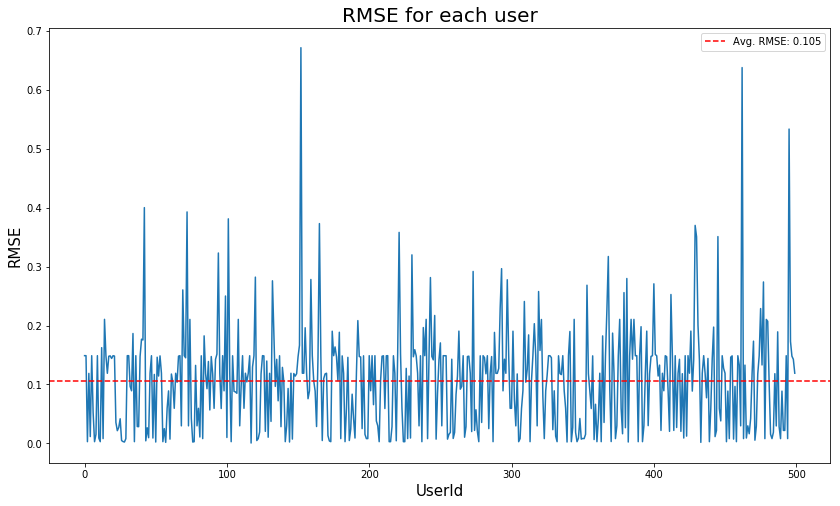

In [219]:
rmse_test = np.sqrt(np.mean((test_data.toarray() - predict_ratings_test)**2, axis = 1)) 
plot_rmse(rmse_test)

## Notes:

1. Increasing **#singual values** decreases RMSE. This also increases the overlap between the recommended books and the books that a user has already rated.

2. Currently, not using actual **BookID** and **UserID**, but they can easily be traced back (example given).

3. Sparsity of the user-item-matrix is still an issue.

4. Only considering users who rated **at least two** books.

5. As most of the predicted ratings are close to 0 and most of the actual ratings are also 0 (i.e. users didn't rate a lot of books), we eventually end-up with lower RMSE. In other words, sparsity (i.e. a lot of 0s)decreases RMSE. If we were to have dense matrix then, probably, RMSE will be a bit higher than current value.